In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf

from keras import datasets, layers, models
import matplotlib.pyplot as plt

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(
        rescale=1./255)

validation_datagen = ImageDataGenerator(rescale=1./255)

# Flow training images in batches of 128 using train_datagen generator
train_data = train_datagen.flow_from_directory(
        '/content/drive/MyDrive/SET Project 2/Photos for Data Training/Training',  # This is the source directory for training images
        target_size=(224, 224),  # All images will be resized to 150x150
        batch_size= 32,
        class_mode='categorical')

# Flow training images in batches of 128 using train_datagen generator
validation_data = validation_datagen.flow_from_directory(
        '/content/drive/MyDrive/SET Project 2/Photos for Data Training/Testing',  # This is the source directory for training images
        target_size=(224, 224),  # All images will be resized to 150x150
        batch_size= 8,
        class_mode='categorical')

Found 373 images belonging to 12 classes.
Found 26 images belonging to 12 classes.


In [ ]:
callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=3,
    verbose=0,
    mode='auto',
    baseline=None,
    restore_best_weights=False,
    start_from_epoch=0)

In [ ]:
# Import the required modules for model creation
from keras import layers
# from keras+ import preprocessing
from keras.models import Sequential

# Setup data augmentation
data_aug = Sequential([
  layers.RandomFlip("horizontal"), # randomly flip images on horizontal edge
  layers.RandomRotation(0.2), # randomly rotate images by a specific amount
  layers.RandomHeight(0.2), # randomly adjust the height of an image by a specific amount
  layers.RandomWidth(0.2), # randomly adjust the width of an image by a specific amount
  layers.RandomZoom(0.2), # randomly zoom into an image
  # preprocessing.Rescaling(1./255) # keep for models like ResNet50V2, remove for EfficientNet
], name="data_augmentation")


In [ ]:
import random
base_model = tf.keras.applications.inception_v3.InceptionV3(weights = "imagenet", include_top=False, input_shape = (224, 224, 3))

# Unfreeze all of the layers in the base model
base_model.trainable = True

# Refreeze every layer except for the last 5
for layer in base_model.layers[:-5]:
  layer.trainable = False

#Adding custom Layers
input = tf.keras.layers.Input(shape = (224, 224, 3))
x = data_aug(input)
x = base_model(x, training = False)
x = tf.keras.layers.Dense(1024, activation="relu")(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(512, activation="relu")(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(256, activation="relu")(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
output = tf.keras.layers.Dense(12, activation="softmax")(x)
model= tf.keras.Model(inputs = input, outputs = output)

87910968/87910968 [==============================] - 3s 0us/step


In [ ]:
test_generator = validation_datagen.flow_from_directory(
        '/content/drive/MyDrive/SET Project 2/Photos for Data Training/Testing',  # This is the source directory for training images
        target_size=(224, 224),  # All images will be resized to 150x150
        batch_size= 30,
        class_mode='categorical')
X_test, y_test = test_generator.next()

Found 26 images belonging to 12 classes.


In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(1e-4), loss='categorical_crossentropy', metrics='Accuracy')

In [ ]:
model_history = model.fit(train_data, epochs = 50, batch_size = 32, validation_data = validation_data, validation_batch_size= 8 )

Epoch 1/50
12/12 [==============================] - 205s 16s/step - loss: 2.2639 - Accuracy: 0.2306 - val_loss: 2.0675 - val_Accuracy: 0.3077
Epoch 2/50
12/12 [==============================] - 45s 4s/step - loss: 1.6901 - Accuracy: 0.4450 - val_loss: 1.6266 - val_Accuracy: 0.4231
Epoch 3/50
12/12 [==============================] - 52s 4s/step - loss: 1.4466 - Accuracy: 0.5710 - val_loss: 1.3665 - val_Accuracy: 0.5769
Epoch 4/50
12/12 [==============================] - 50s 4s/step - loss: 1.0595 - Accuracy: 0.6863 - val_loss: 1.1485 - val_Accuracy: 0.6154
Epoch 5/50
12/12 [==============================] - 52s 4s/step - loss: 0.9075 - Accuracy: 0.7131 - val_loss: 1.0380 - val_Accuracy: 0.6154
Epoch 6/50
12/12 [==============================] - 48s 4s/step - loss: 0.7754 - Accuracy: 0.7507 - val_loss: 0.9920 - val_Accuracy: 0.6538
Epoch 7/50
12/12 [==============================] - 44s 4s/step - loss: 0.7952 - Accuracy: 0.7105 - val_loss: 0.9480 - val_Accuracy: 0.6538
Epoch 8/50
12/12 [

In [ ]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
predict = model.predict_generator(X_test)
#roc_auc_score(y_test, predict, multi_class='ovr')
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(12):  #num_Class
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], predict[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
print(roc_auc)

<ipython-input-12-d79997580d80>:3: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predict = model.predict_generator(X_test)


{0: 1.0, 1: 1.0, 2: 1.0, 3: 0.9710144927536233, 4: 1.0, 5: 1.0, 6: 1.0, 7: 1.0, 8: 0.9855072463768116, 9: 1.0, 10: 1.0, 11: 1.0}


In [ ]:
model.evaluate(X_test,y_test)

1/1 [==============================] - 2s 2s/step - loss: 0.5072 - Accuracy: 0.8077


[0.5072307586669922, 0.807692289352417]

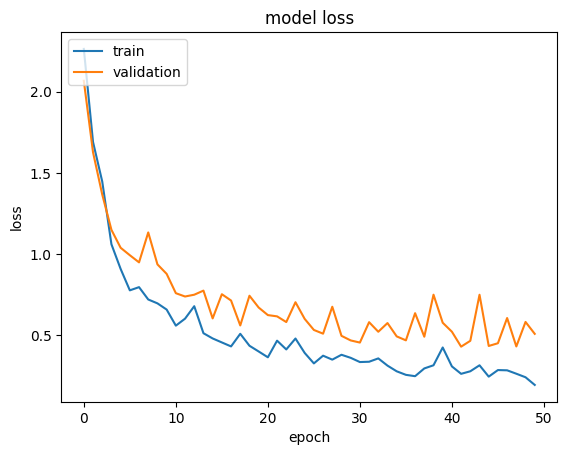

In [ ]:
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
model.save("/content/drive/MyDrive/SET Project 2/my_model4")

In [ ]:
import numpy as np
arr=np.array([[1,2,3]])
arr.shape

(1, 3)